<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/%2001-banners_epsilon.ipynb%20" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epsilon-Greedy

In [3]:
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Apply the default theme
sns.set_theme()

## Environment

In [4]:
class BernoulliEnvironment(object):
  def __init__(self, params: List[float]):
    self._params = params
    self._observe()

  def reset(self):
    return self._observe()

  def _observe(self) -> List[float]:
    self._observation = np.random.rand(1)
    return self._observation

  def step(self, action: int) -> Tuple[int, float]:
    ret = 0 if self._observe()[0] > self._params[action] else 1
    return (ret, self._observation[0])
  
  def best_action(self):
    return np.argmax(self._params)

In [8]:
env = BernoulliEnvironment([0.2, 0.45, 0.65])
print(f'The environment best action is {env.best_action()}')

action = 2 #@param

ret = env.step(action)
print(f'reward={ret[0]}, observarion={ret[1]}')

The environment best action is 2
reward=1, observarion=0.23540787555990483


In [ ]:
class NormalEnvironment(object):
  def __init__(self, params: List[Tuple[float, float]]):
    self._params = params
    self._observe()

  def reset(self):
    return self._observe()

  def _observe(self) -> List[float]:
    self._observation = np.random.normal(1, 1, 5)
    return self._observation

  def step(self, action: int) -> Tuple[int, float]:
    ret = 0 if self._observe()[0] > self._params[action] else 1
    return (ret, self._observation[0])

In [ ]:
#np.random.normal([0.5, 0.25], [1.0, 0.5], 5)

## Policy

In [9]:
class EpsilonGreedyPolicy(object):
  def __init__(self, epsilon: float, values):
    self._epsilon = epsilon
    self._values = values

  def action(self) -> int:
    val_max = max(self._values)
    if np.random.rand() > self._epsilon:
      return np.random.choice(
          [i for i, val in enumerate(self._values) if val == val_max])
    else:
      return np.random.randint(len(self._values))

In [10]:
env = EpsilonGreedyPolicy(epsilon=0.1, values=[1, 2, 3])
action = env.action()
print(f'{action}')

2


## Agent

In [11]:
class EpsilonGreedyAgent(object):
  
  def __init__(self, n: int, epsilon: float = 0.1):
    self._epsilon = epsilon
    self._n = n

    self.reset()

    self.policy = EpsilonGreedyPolicy(self._epsilon, self._values)

  def reset(self):
    self._counts = [0] * self._n
    self._values = [0.0] * self._n

  def train(self, experience: Dict[str, int]):
    action = experience['action']
    reward = experience['reward']

    self._counts[action] += 1

    value = self._values[action]
    n = self._counts[action]

    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward

In [12]:
ag = EpsilonGreedyAgent(3)

experience = {'action': 2, 'reward': 1}
ag.train(experience)
print(f'values={ag._values}')

experience = {'action': 2, 'reward': 0}
ag.train(experience)
print(f'values={ag._values}')

values=[0.0, 0.0, 1.0]
values=[0.0, 0.0, 0.5]


## Utils

In [349]:
def create_accuracies(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy() 
  df['price'] = 1
  df = pd.pivot_table(df, index='trial', columns=['action'], aggfunc=np.sum).price
  df['sum'] = df.sum(axis=1)
  df = df.loc[:,:].div(df["sum"], axis=0)
  df.columns = [f'action_{action}' for action in df.columns]

  return df.reset_index().fillna(0)


def plot_accuracy(df: pd.DataFrame, best_action):
  plt.figure(figsize=(10, 7))
  
  #if hyperparameter:
  #  for parameter in df[hyperparameter].unique():
  #    plt.plot(
  #        df[df[hyperparameter] == parameter]['trial'],
  #        df[df[hyperparameter] == parameter][f'arm_{best_arm}'],
  #        label=parameter
  #    )
  #    plt.legend(title=hyperparameter)
  #else:
  #  plt.plot(df.trial, df[f'arm_{best_arm}']) 
  for epsilon in df.epsilon.unique():
    df_acc = create_accuracies(df[df.epsilon == epsilon])
    
    plt.plot(
        df_acc.trial, 
        df_acc[f'action_{best_action}'], 
        label=f'action={best_action} (epsilon={epsilon})'
    )

  plt.xlim(0)
  plt.ylim(0, 1)
  plt.xlabel('Number of trials')
  plt.ylabel('Probability of Selecting Best Arm')
  plt.legend()
  #plt.title(f'Accuracy of the {algorithm_name} Algorithm')
  plt.show()


def plot_actions(df: pd.DataFrame):
  #probabilities = sorted(range(env.n_arms), key=lambda k: env.params[k][0], reverse=True)
  df_acc = create_accuracies(df)

  plt.figure(figsize=(10, 7))

  for action in df.action.unique():
      plt.plot(
          df_acc.trial,
          df_acc[f'action_{action}'],
          label=f'action={action}'
      )
  #plt.legend(title='Sorted Actions')

  plt.xlim(0)
  plt.xlabel('Number of Trials')
  plt.ylabel('Probability of Selecting Each Action')
  # plt.title('Arm Selection Rate of the {} Algorithm'.format(algorithm_name))
  plt.show()


def plot_cumsum(df: pd.DataFrame, show_actions=False):
  plt.figure(figsize=(10, 7))

  df = df.copy()

  if show_actions:
    df_actions = df.groupby(['trial', 'action']).mean().reset_index()

    for action in sorted(df.action.unique()):
      plt.plot(
          df_actions[df_actions['action']==action].trial, 
          df_actions[df_actions['action']==action].action_cum_sum,
          label=f'action={int(action)} cumulative reward'
      )

  df_all = df.groupby('trial')['cum_sum'].mean().reset_index()

  plt.plot(
    df_all.trial, 
    df_all.cum_sum, 
    linestyle='--', 
    label='avg. agent cumulative reward'
  )

  plt.xlim(0)
  plt.xlabel('Number of trials')
  plt.ylabel('Cumulative Reward')
  plt.legend()
  #plt.title(f'Cumulative Reward of the {algorithm_name} Algorithm')
  plt.show()

## Experiment

In [300]:
def run(environment: object, agent: object, trials=100):
  trajectory = []

  experience = {'trial': 0, 'action': -1, 'observation': 0, 'reward': 0}

  for i in range(trials):
    experience['trial'] = i + 1
    experience['action'] = agent.policy.action()
    experience['reward'], experience['observation'] = environment.step(experience['action'])

    agent.train(experience)

    #df_trajectory = df_trajectory.append(experience, ignore_index=True)
    trajectory.append(experience.copy())
    
  df_trajectory = pd.DataFrame.from_dict(trajectory)
  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'})

In [157]:
environment = BernoulliEnvironment([0.25, 0.4, 0.67])
step = environment.reset()

agent = EpsilonGreedyAgent(3)
experience = {'action': -1, 'observation': 0, 'reward': 0}

df_trajectory = run(environment, agent, trials=10)

print(f'\nvalues={agent._values}')


values=[0.0, 0.0, 0.875]


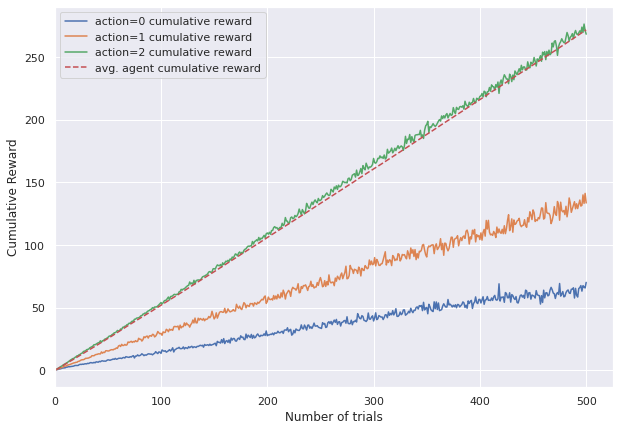

In [340]:
plot_cumsum(df_trajectory.copy(), show_actions=True)

### Epochs

In [333]:
def experiment(epsilons: List[float], epochs: int = 1, trials: int = 10):
  trajectories = []

  environment = BernoulliEnvironment([0.25, 0.4, 0.67])
  params = {'best_action': environment.best_action()}
  for epsilon in epsilons:
    for epoch in range(epochs):
      step = environment.reset()
      agent = EpsilonGreedyAgent(3, epsilon=epsilon)

      df = run(environment, agent, trials=trials)
      df['epoch'] = epoch + 1
      df['epsilon'] = epsilon

      trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params

In [358]:
df_trajectory, params = experiment(epsilons=[1.0, 0.1, 0.01, 0], epochs=100, trials=2500)
#df_trajectory

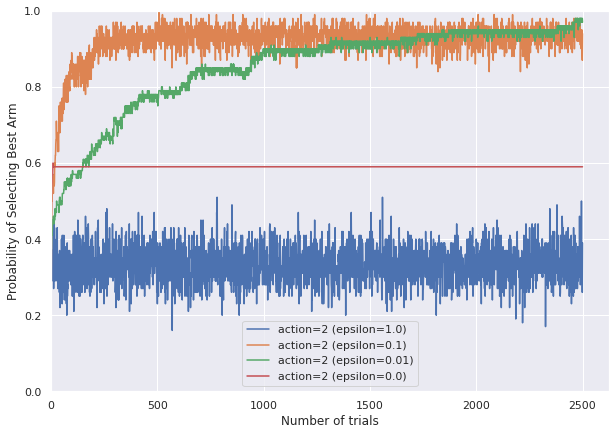

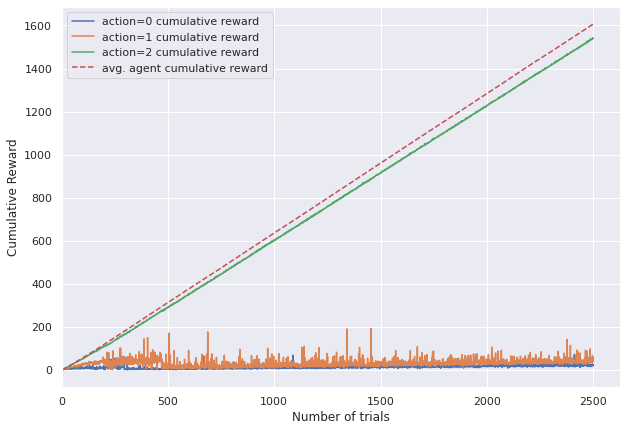

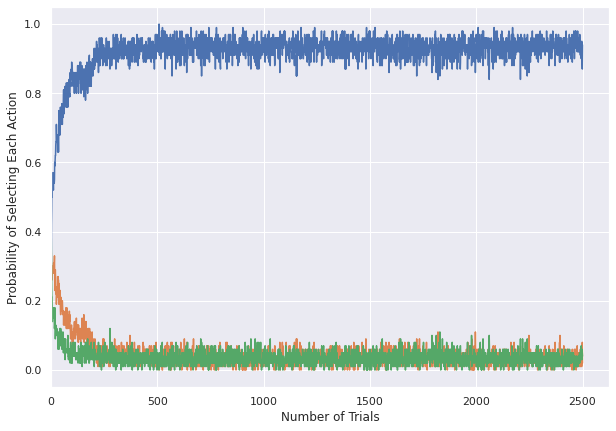

In [359]:
plot_accuracy(df_trajectory, params['best_action'])
plot_cumsum(df_trajectory[df_trajectory.epsilon == 0.1], show_actions=True)
plot_actions(df_trajectory[df_trajectory.epsilon == 0.1])